# Memory usage

The [first benchmark](http://www.xavierdupre.fr/app/_benchmarks/helpsphinx/sklbench_results/index.html) based on [scikti-learn's benchmark](https://github.com/jeremiedbb/scikit-learn_benchmarks) shows high peaks of memory usage for the python runtime on linear models. Let's see how to measure that.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Artificial huge data 

In [2]:
import numpy
N, nfeat = 300000, 200
N * nfeat * 8 / 1e9

0.48

In [3]:
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
X.shape, y.shape

((300000, 200), (300000, 50))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)

In [5]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
from mlprodict.onnxrt import to_onnx, OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')

The maximum opset needed by this model is only 1.


Let's minimize the cost of verifications on scikit-learn's side.

In [7]:
from sklearn import set_config
set_config(assume_finite=True)

## Profiling the prediction function

In [8]:
from pyquickhelper.pycode.profiling import profile
print(profile(lambda: clr.predict(X_test), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 10:27:49  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.274     CPU time: 0.469
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-fffc5656-9b4c-4bdf-9a5b-b30048a6c9f6.json

0.274 profile  pyquickhelper\pycode\profiling.py:49
|- 0.263 <lambda>  <ipython-input-44-1097e70fe6c7>:2
|  `- 0.263 predict  sklearn\linear_model\base.py:208
|     `- 0.263 _decision_function  sklearn\linear_model\base.py:201
|        |- 0.187 safe_sparse_dot  sklearn\utils\extmath.py:117
|        |  `- 0.187 dot  <__array_function__ internals>:2
|        `- 0.076 [self]  
`- 0.011 [self]  




In [9]:
import numpy

def nastype32(mat):
    return mat.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': nastype32(X_test)}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 10:27:51  Samples:  5
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.276     CPU time: 0.375
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-fffc5656-9b4c-4bdf-9a5b-b30048a6c9f6.json

0.276 profile  pyquickhelper\pycode\profiling.py:49
|- 0.271 <lambda>  <ipython-input-45-da4aa05db7ed>:6
|  |- 0.149 nastype32  <ipython-input-45-da4aa05db7ed>:3
|  |- 0.099 run  mlprodict\onnxrt\onnx_inference.py:593
|  |  `- 0.099 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:651
|  |     `- 0.099 run  mlprodict\onnxrt\onnx_inference_node.py:108
|  |        `- 0.099 run  mlprodict\onnxrt\ops_cpu\_op.py:163
|  |           `- 0.099 run  mlprodict\onnxrt\ops_cpu\_op.py:138
|  |              `- 0.099 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:26
|  |                 |- 0.087 dot  <__array_function__ internals>:2
|  |          

Most of the time is taken out into casting into float. Let's take it out.

In [10]:
X_test32 = X_test.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': X_test32}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 10:28:00  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.100     CPU time: 0.188
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-fffc5656-9b4c-4bdf-9a5b-b30048a6c9f6.json

0.100 profile  pyquickhelper\pycode\profiling.py:49
|- 0.094 <lambda>  <ipython-input-46-fe055596e921>:3
|  `- 0.094 run  mlprodict\onnxrt\onnx_inference.py:593
|     `- 0.094 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:651
|        `- 0.094 run  mlprodict\onnxrt\onnx_inference_node.py:108
|           `- 0.094 run  mlprodict\onnxrt\ops_cpu\_op.py:163
|              `- 0.094 run  mlprodict\onnxrt\ops_cpu\_op.py:138
|                 `- 0.094 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:26
|                    |- 0.083 dot  <__array_function__ internals>:2
|                    `- 0.011 [self]  
`- 0.006 [self]  




Much better.

## Memory profiling

In [11]:
%matplotlib inline

In [12]:
from memory_profiler import memory_usage
memprof_skl = memory_usage((clr.predict, (X_test, )), timestamps=True, interval=0.01)

In [13]:
memprof_skl

[(1496.69921875, 1564734691.7974305),
 (1496.71484375, 1564734695.393255),
 (1510.41015625, 1564734695.4032586),
 (1525.515625, 1564734695.4142048),
 (1545.16015625, 1564734695.4251673),
 (1558.984375, 1564734695.435171),
 (1576.69140625, 1564734695.4461412),
 (1595.5390625, 1564734695.457081),
 (1599.71875, 1564734695.468053),
 (1599.71875, 1564734695.479053),
 (1599.71875, 1564734695.4900227),
 (1599.71875, 1564734695.500966),
 (1599.71875, 1564734695.5119674),
 (1599.71875, 1564734695.522943),
 (1599.71875, 1564734695.5338743),
 (1599.71875, 1564734695.5448453),
 (1599.71875, 1564734695.5558171),
 (1599.71875, 1564734695.5658205),
 (1599.71875, 1564734695.576796),
 (1599.71875, 1564734695.587731),
 (1599.71875, 1564734695.5987031),
 (1611.01953125, 1564734695.6096718),
 (1628.46484375, 1564734695.6206427),
 (1645.67578125, 1564734695.6316133),
 (1663.09765625, 1564734695.642586),
 (1680.66015625, 1564734695.6535554),
 (1698.125, 1564734695.664525),
 (1626.515625, 1564734695.675496),

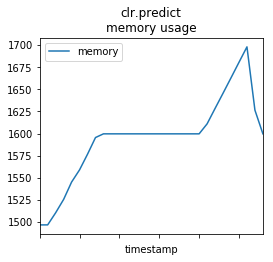

In [14]:
import matplotlib.pyplot as plt
from pandas import DataFrame, to_datetime

def mem_profile_plot(mem, title):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    df = DataFrame(mem, columns=["memory", "timestamp"])
    df["timestamp"] = to_datetime(df.timestamp)
    df["timestamp"] -= df.timestamp.min()
    df.set_index("timestamp").plot(ax=ax)
    ax.set_title(title + "\nmemory usage")
    return ax

mem_profile_plot(memprof_skl, "clr.predict");

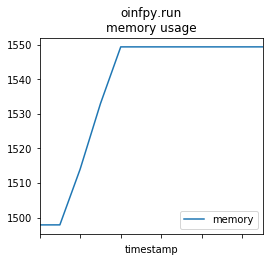

In [15]:
memprof_onx = memory_usage((oinfpy.run, ({'X': X_test32}, )), timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx, "oinfpy.run");

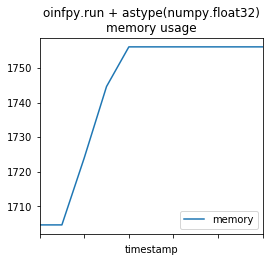

In [16]:
memprof_onx2 = memory_usage((oinfpy.run, ({'X': X_test.astype(numpy.float32, copy=False)}, )),
                           timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx2, "oinfpy.run + astype(numpy.float32)");

This is not very informative.

## Memory profiling outside the notebook

More precise.

In [17]:
%%writefile mprof_clr_predict.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def clr_predict():
    clr.predict(X_test)
    
clr_predict()

Overwriting mprof_clr_predict.py


In [18]:
!python -m memory_profiler mprof_clr_predict.py --timestamp

Filename: mprof_clr_predict.py

Line #    Mem usage    Increment   Line Contents
    20   1253.4 MiB   1253.4 MiB   @profile
    21                             def clr_predict():
    22   1254.2 MiB      0.8 MiB       clr.predict(X_test)




The notebook seems to increase the memory usage.

In [19]:
%%writefile mprof_onnx_run.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnxrt import to_onnx, OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')
X_test32 = X_test.astype(numpy.float32)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict():
    oinfpy.run({'X': X_test32})
    
oinfpy_predict()

Overwriting mprof_onnx_run.py


In [20]:
!python -m memory_profiler mprof_onnx_run.py --timestamp

Filename: mprof_onnx_run.py

Line #    Mem usage    Increment   Line Contents
    25   1504.7 MiB   1504.7 MiB   @profile
    26                             def oinfpy_predict():
    27   1504.9 MiB      0.1 MiB       oinfpy.run({'X': X_test32})




The maximum opset needed by this model is only 1.


In [21]:
%%writefile mprof_onnx_run32.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnxrt import to_onnx, OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict32():
    oinfpy.run({'X': X_test.astype(numpy.float32)})
    
oinfpy_predict32()

Writing mprof_onnx_run32.py


In [22]:
!python -m memory_profiler mprof_onnx_run32.py --timestamp

Filename: mprof_onnx_run32.py

Line #    Mem usage    Increment   Line Contents
    24   1298.6 MiB   1298.6 MiB   @profile
    25                             def oinfpy_predict32():
    26   1298.8 MiB      0.1 MiB       oinfpy.run({'X': X_test.astype(numpy.float32)})




The maximum opset needed by this model is only 1.
